<a href="https://colab.research.google.com/github/dbokan1/DNN_Maze_Solver/blob/main/ANNTMazeSolver.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

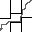

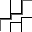

0


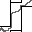

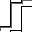

1


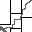

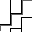

2


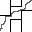

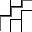

3


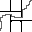

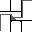

4


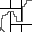

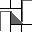

5


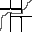

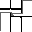

6


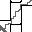

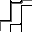

7


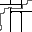

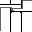

8


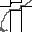

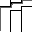

9


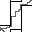

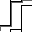

10


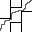

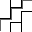

11


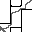

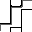

12


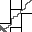

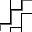

13


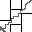

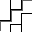

14


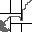

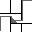

15


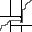

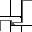

16


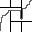

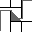

17


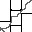

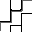

18


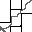

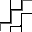

19


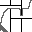

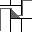

20


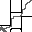

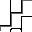

21


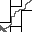

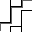

22


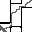

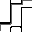

23


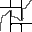

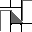

24


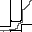

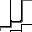

25


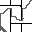

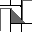

26


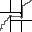

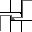

27


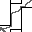

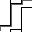

28


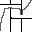

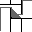

29


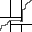

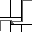

30


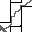

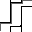

31


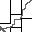

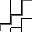

32


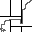

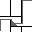

33


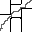

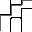

34


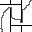

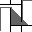

35


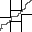

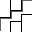

36


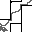

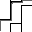

37


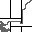

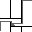

38


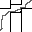

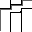

39


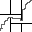

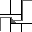

40


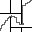

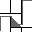

41


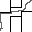

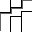

42


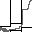

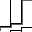

43


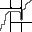

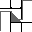

44


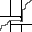

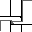

45


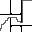

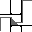

46


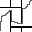

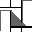

47


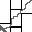

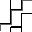

48


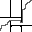

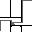

49


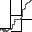

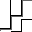

50


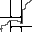

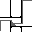

51


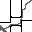

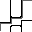

52


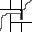

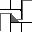

53


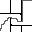

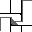

54


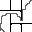

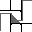

55


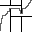

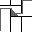

56


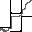

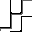

57


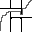

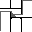

58


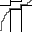

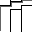

59


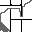

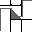

60


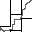

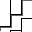

61


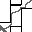

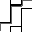

62


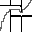

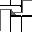

63


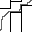

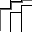

64


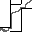

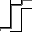

65


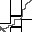

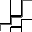

66


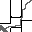

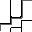

67


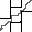

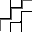

68


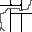

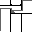

69


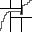

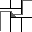

70


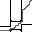

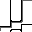

71


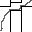

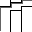

72


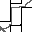

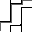

73


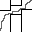

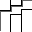

74


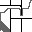

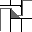

75


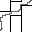

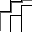

76


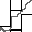

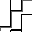

77


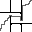

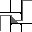

78


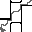

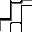

79


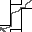

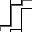

80


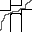

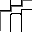

81


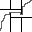

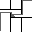

82


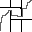

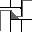

83


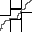

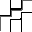

84


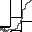

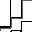

85


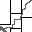

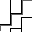

86


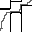

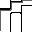

87


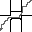

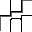

88


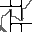

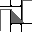

89


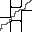

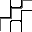

90


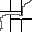

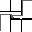

91


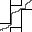

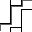

92


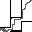

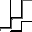

93


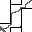

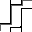

94


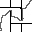

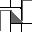

95


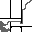

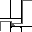

96


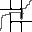

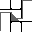

97


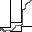

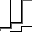

98


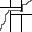

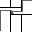

99
37


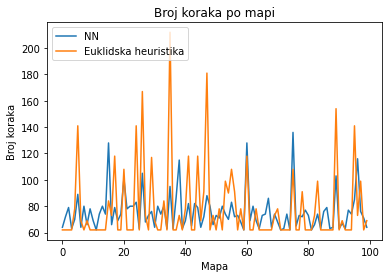

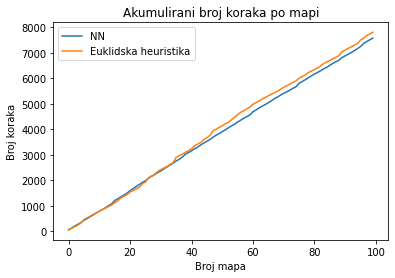

In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
from collections import deque
import random
from tensorflow.keras import layers
import copy
from PIL import Image
import math
import matplotlib.pyplot as plt

# daje dataset- niz labirinata sa ucrtanim ciljem i trenutnom pozicijom u formatu za treniranje nn
def prepSet(s):
  rez = np.empty([len(s), 32, 32,1]).astype(float)
  for i in range(len(s)):
    x=copy.deepcopy(s[i][0]).astype(float)
    x[s[i][1]][s[i][2]]=70
    x[31][0]=210
    for k in range(len(x)):
      for j in range(len(x[0])):
        x[k][j] = x[k][j]/255.
    x=x.reshape(32,32,1)
    rez[i]=x
  return rez

# Sprema jedan labirint u format za slanje nn
def prepGrid(grid,s):
  rez = copy.deepcopy(grid).astype(float)
  rez[s[0]][s[1]]=100
  rez[31][0]=200
  for i in range(len(rez)):
      for j in range(len(rez[0])):
          rez[i][j]=rez[i][j]/255.
  rez=rez.reshape(1,32,32,1)
  return rez


def agent():
  init = tf.keras.initializers.HeUniform()
  model = keras.Sequential()
  model.add(layers.Conv2D(16, kernel_size=2,padding="same", activation='relu', input_shape=(32, 32, 1)))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(16, kernel_size=2,padding="same", activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(16, kernel_size=2,padding="same", activation='relu'))
  model.add(layers.Flatten())
  model.add(layers.Dense(64, activation='relu'))
  model.add(layers.Dense(1))
  model.compile(loss=tf.keras.losses.Huber(), optimizer=tf.keras.optimizers.Adam(lr=0.1), metrics=['accuracy'])
  return model

def agent2():
  init = tf.keras.initializers.HeUniform()
  model = keras.Sequential()
  model.add(layers.Conv2D(16, kernel_size=2, activation='relu', input_shape=(32, 32, 1)))
  # model.add(layers.MaxPooling2D((2, 2)))
  # model.add(layers.Conv2D(16, kernel_size=2, activation='relu'))
  # model.add(layers.MaxPooling2D((2, 2)))
  # model.add(layers.Conv2D(16, kernel_size=2, activation='relu'))
  model.add(layers.Flatten())
  model.add(layers.Dense(64, activation='relu'))
  model.add(layers.Dense(64, activation='relu'))
  model.add(layers.Dense(64, activation='relu'))
  model.add(layers.Dense(64, activation='relu'))
  model.add(layers.Dense(64, activation='relu'))
  model.add(layers.Dense(1))
  model.compile(loss=tf.keras.losses.Huber(), optimizer=tf.keras.optimizers.Adam(lr=0.001), metrics=['accuracy'])
  return model



# ova dva niza nam predstavljaju dataset za treniranje
# u pozicije ubacujemo labirinte sa ucrtanim pozicijama
# u troskove ubacujemo broj koraka od trenutne pozicije do cilja
pozicije=[]
troskovi=[]

delta = [[-1, 0], # go up
         [ 0,-1], # go left
         [ 1, 0], # go down
         [ 0, 1]] # go right

#vrijednost=trosak+heuristika
#struktura: open sadrzi [vrijednost, trosak puta, x, y]

testiranje=[]

# funkcija za exploreanje i generisanje training seta
def djikstra(grid):
  open = [[0,31,0]]
  opens=[]
  closeds=[]
  grid2 = copy.deepcopy(grid)
  done=False
  while len(open)>0:
    open2=[]
    while len(open)>0:
      [g,x,y]=open.pop()
      s=[x,y]
      for move in delta:
        if s[0] + move[0] < len(grid) and s[1] + move[1] < len(grid[0]) and s[0] + move[0] >= 0 and s[1] + move[1] >= 0 and grid[s[0] + move[0]][s[1] + move[1]]!=0:
          g2 = g+5
          element=[g2, s[0] + move[0],s[1] + move[1]]
          if [element[1],element[2]] not in closeds:
            open2.append(element)
            closeds.append([element[1],element[2]])
            grid2[element[1]][element[2]]=element[0]
            pozicije.append([grid,element[1], element[2]])
            troskovi.append(element[0])
    open=copy.deepcopy(open2)
  return 0


def heuristika(x,y):
    return (31.-x+y)

# prolazak kroz labirint sa NN kao heuristikom
def Asearch(grid):
    dnn = keras.models.load_model("/content/drive/MyDrive/train/v5") # ucitavanje treniranog modela za pretragu
    end = False
    open = [[0,0,31]] #startna pozicija
    closed=[]
    goal = [31,0]
    grid2=copy.deepcopy(grid) #grid za prikaz putanje
    i=0
    while end == False:
        open.sort()
        open.reverse()
        [value,x,y]= open.pop()
        closed.append([x,y])
        i=i+1
        grid2[x][y]=100
        #print(grid)
        s=[x,y]
        for move in delta:
            if s[0] + move[0] < len(grid) and s[1] + move[1] < len(grid[0]) and s[0] + move[0] >= 0 and s[1] + move[1] >= 0 and grid2[s[0] + move[0]][s[1] + move[1]] == 255:
                n2=[s[0] + move[0],s[1] + move[1]]
                c=dnn.predict(prepGrid(grid,n2))
                if n2 not in closed and [c,n2[0],n2[1]] not in open:
                  open.append([c,n2[0],n2[1]])
                if s[0] + move[0] == goal[0] and s[1] + move[1] == goal[1]:
                    end = True
                    break
        if len(open) == 0:
            end = True
    img = Image.fromarray(grid2)
    display(img)
    return i


# prolazak kroz labirint sa euklidskom heuristikom
def Aheursearch(grid):
    end = False
    open = [[0,0,31]] #startna pozicija
    closed=[]
    goal = [31,0]
    grid2=copy.deepcopy(grid) #grid za prikaz putanje
    i=0
    while end == False:
        open.sort()
        open.reverse()
        [value,x,y]= open.pop()
        closed.append([x,y])
        i=i+1
        grid2[x][y]=100
        #print(grid)
        s=[x,y]
        for move in delta:
            if s[0] + move[0] < len(grid) and s[1] + move[1] < len(grid[0]) and s[0] + move[0] >= 0 and s[1] + move[1] >= 0 and grid2[s[0] + move[0]][s[1] + move[1]] == 255:
                n2=[s[0] + move[0],s[1] + move[1]]
                c=heuristika(n2[0],n2[1])
                if n2 not in closed and [c,n2[0],n2[1]] not in open:
                  open.append([c,n2[0],n2[1]])
                if s[0] + move[0] == goal[0] and s[1] + move[1] == goal[1]:
                    end = True
                    break
        if len(open) == 0:
            end = True
    img = Image.fromarray(grid2)
    display(img)
    return i


def testiranje():
  A=[]
  Acum=[]
  B=[]
  Bcum=[]
  acum=0
  bcum=0
  brojac=0
  for i in range(100): # ucitavanje 100 labirinata za testiranje
    naziv="/content/drive/MyDrive/train/"+str(i)+".png"
    if i!=611:
      im = Image.open(naziv)
      y=np.array(im)
      a=Asearch(y)
      b=Aheursearch(y)
      acum=acum+a
      bcum=bcum+b
      Acum.append(acum)
      Bcum.append(bcum)
      if a<b:
        brojac=brojac+1
      A.append(a)
      B.append(b)
      print(i)
  # plotanje broja napravljenih koraka po pojedinacnom labirintu
  print(brojac)
  plt.plot(A)
  plt.plot(B)
  plt.title('Broj koraka po mapi')
  plt.ylabel('Broj koraka')
  plt.xlabel('Mapa')
  plt.legend(['NN', 'Euklidska heuristika'], loc='upper left')
  plt.show()
  # plot akumuliranih koraka
  plt.plot(Acum)
  plt.plot(Bcum)
  plt.title('Akumulirani broj koraka po mapi')
  plt.ylabel('Broj koraka')
  plt.xlabel('Broj mapa')
  plt.legend(['NN', 'Euklidska heuristika'], loc='upper left')
  plt.show()


def treniranje():
  for i in range(800): # ucitavanje 800 labirinata za treniranje
  naziv="/content/drive/MyDrive/train/"+str(i)+".png"
  if i!=611:
    im = Image.open(naziv)
    y=np.array(im)
    djikstra(y)

  model=agent2()
  troskovi=np.asarray(troskovi)
  history=model.fit(prepSet(pozicije),troskovi,epochs=1000,verbose=1,batch_size=32,shuffle=True)
  model.save("/content/drive/MyDrive/train/v5")
  
  # plotanje learning curvea i lossa
  print(history.history.keys())
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()


treniranje()
testiranje()




In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!python --version



Python 3.7.12


# New Section